# **Pokémon Diffusion<a id="top"></a>**

> #### ``04-Training-Diffusion-Model.ipynb``

<i><small>**Alumno:** Alejandro Pequeño Lizcano<br>Última actualización: 08/04/2024</small></i></div>

TODO: INTRODUCIR MEJOR

Como paso final, se procede a entrenar el modelo de difusión. Para ello, se ha definido la función ``training()`` que engloba todo el proceso de difusión completo, tanto hacia adelante como hacia atrás y los ploteos de las muestras generadas. Para implementar el training hemos usado el **Algoritmo 1** de [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) y se ha modificado para que sea capaz de generar imágenes condicionadas a una etiqueta.

<div style="text-align:center">
<img src="../figures/notebook_figures/algorithm1_training.png" width="40%" height="30%" />
</div>

También se han añadido unas funcionalidades extra que permiten guardar cada epoch el modelo y sus pesos en un fichero con extensión .h5. Esto se hace para poder cargar el modelo y continuar el entrenamiento desde donde se quedó en caso de que se interrumpa por algún motivo.

><span style="color: red; font-size: 1.5em;">&#9888;</span> <i><small>**NOTA:** Por cada epoch se guarda en un fichero con extensión .h5 tanto el modelo como sus pesos. Este proceso se realiza ya que todo el entrenamiento es muy costoso y si se interrumpe por algún motivo, se puede volver a cargar el modelo y continuar el entrenamiento desde donde se quedó.
>
>También cabe destacar que para una mayor eficiencia en el entrenamiento, se ha optado por realizar el ``sampling()`` cada 20 epochs.
</small></i>

# 0. Imports

In [1]:
# Import necessary libraries
# =====================================================================
import os

# Configurar el nivel de logging para mostrar solo errores
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import configparser
import tensorflow as tf

# Import src code
from src.model.build_unet import build_unet
from src.utils.utils import PROJECT_DIR, DATA_PATH
from src.visualization import visualize

# from src.model.diffusion_model import *
from src.model.overfitting_test import *

In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(PROJECT_DIR / "config.ini")

# Hyperparameters
config_hp = config["hyperparameters"]

IMG_SIZE = int(config_hp["img_size"])
NUM_CLASSES = int(config_hp["num_classes"])
BATCH_SIZE = int(config_hp["batch_size"])
EPOCHS = int(config_hp["epochs"])
T = int(config_hp["T"])  # number of diffusion steps
BETA_START = float(config_hp["beta_start"])
BETA_END = float(config_hp["beta_end"])
s = float(config_hp["s"])  # scale factor for the variance curve
SCHEDULER = config_hp["scheduler"]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # TODO: ADD TO CONFIG FILE
loss_fn = tf.keras.losses.MeanSquaredError()

# 1. Dataset

- The shape of the dataset is: (64, 64, 64, 3) => batch_size: 64, height: 64, width: 64, channels: 3
- The shape of the dataset labels is: (64, 18) => batch_size: 64, number of labels: 18


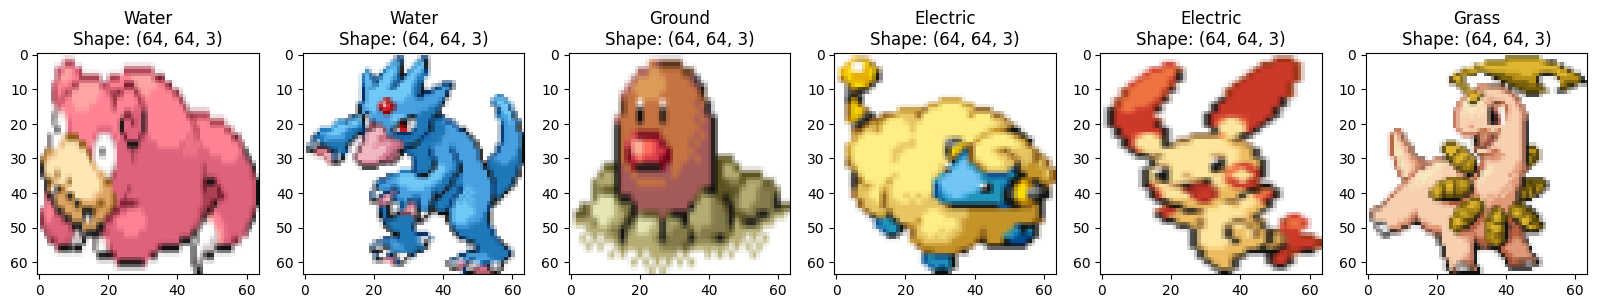

In [4]:
dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset"
poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

# 2. Model

In [5]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, T, BETA_START, BETA_END, s, "linear"
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer)

## 2.1. Training

Epoch 1/1000


I0000 00:00:1713901579.403171  105503 service.cc:145] XLA service 0x749438047d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713901579.403194  105503 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
W0000 00:00:1713901579.832133  105503 random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform
I0000 00:00:1713901581.293902  105826 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5377', 492 bytes spill stores, 492 bytes spill loads

I0000 00:00:1713901581.906556  105818 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5377', 440 bytes spill stores, 440 bytes spill loads

I0000 00:00:1713901600.228450  105503 device_compiler.h:188] Com

127/127 ━━━━━━━━━━━━━━━━━━━━ 48s 169ms/step - loss: 0.4766
Epoch 2/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.1691
Epoch 3/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0978
Epoch 4/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.1193
Epoch 5/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0724
Epoch 6/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0995
Epoch 7/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0981
Epoch 8/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0808
Epoch 9/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0905
Epoch 10/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0764
Epoch 11/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0592
Epoch 12/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0984
Epoch 13/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - loss: 0.0665
Epoch 14/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - loss: 0.0902


Sampling sprite: 100%|██████████| 999/999 [00:43<00:00, 23.10it/s]


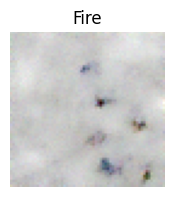

127/127 ━━━━━━━━━━━━━━━━━━━━ 65s 515ms/step - loss: 0.0652
Epoch 21/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0687
Epoch 22/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0490
Epoch 23/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0863
Epoch 24/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0637
Epoch 25/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 169ms/step - loss: 0.0589
Epoch 26/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0383
Epoch 27/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0734
Epoch 28/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 168ms/step - loss: 0.0919
Epoch 29/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - loss: 0.0674
Epoch 30/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - loss: 0.0703
Epoch 31/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - loss: 0.0719
Epoch 32/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - loss: 0.0575
Epoch 33/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - loss:

Sampling sprite: 100%|██████████| 999/999 [00:40<00:00, 24.53it/s]


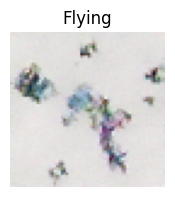

127/127 ━━━━━━━━━━━━━━━━━━━━ 63s 496ms/step - loss: 0.0451
Epoch 41/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0457
Epoch 42/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0800
Epoch 43/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0613
Epoch 44/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0392
Epoch 45/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0680
Epoch 46/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0631
Epoch 47/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0650
Epoch 48/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0674
Epoch 49/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0493
Epoch 50/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0425
Epoch 51/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0572
Epoch 52/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0562
Epoch 53/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss:

Sampling sprite: 100%|██████████| 999/999 [00:40<00:00, 24.51it/s]


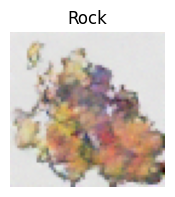

127/127 ━━━━━━━━━━━━━━━━━━━━ 63s 498ms/step - loss: 0.0480
Epoch 61/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0452
Epoch 62/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0429
Epoch 63/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0531
Epoch 64/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0457
Epoch 65/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0714
Epoch 66/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0542
Epoch 67/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0535
Epoch 68/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0526
Epoch 69/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0577
Epoch 70/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0693
Epoch 71/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0619
Epoch 72/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0468
Epoch 73/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss:

Sampling sprite: 100%|██████████| 999/999 [00:40<00:00, 24.40it/s]


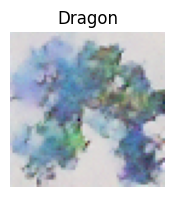

127/127 ━━━━━━━━━━━━━━━━━━━━ 63s 499ms/step - loss: 0.0570
Epoch 81/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0642
Epoch 82/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0484
Epoch 83/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0447
Epoch 84/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0503
Epoch 85/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0487
Epoch 86/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0482
Epoch 87/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0538
Epoch 88/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0847
Epoch 89/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0791
Epoch 90/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0592
Epoch 91/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0462
Epoch 92/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0405
Epoch 93/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss:

Sampling sprite: 100%|██████████| 999/999 [00:41<00:00, 24.23it/s]


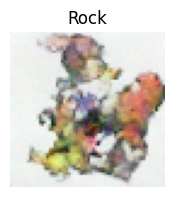

127/127 ━━━━━━━━━━━━━━━━━━━━ 63s 502ms/step - loss: 0.0552
Epoch 101/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0525
Epoch 102/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0844
Epoch 103/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0622
Epoch 104/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 168ms/step - loss: 0.0669
Epoch 105/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0338
Epoch 106/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0626
Epoch 107/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0409
Epoch 108/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0554
Epoch 109/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0408
Epoch 110/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0647
Epoch 111/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0626
Epoch 112/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0534
Epoch 113/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms

Sampling sprite: 100%|██████████| 999/999 [00:41<00:00, 24.30it/s]


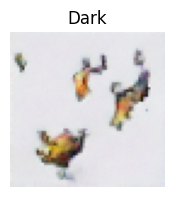

127/127 ━━━━━━━━━━━━━━━━━━━━ 63s 501ms/step - loss: 0.0586
Epoch 121/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0695
Epoch 122/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0573
Epoch 123/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - loss: 0.0396
Epoch 124/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - loss: 0.0646
Epoch 125/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0429
Epoch 126/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0673
Epoch 127/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0604
Epoch 128/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0587
Epoch 129/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0412
Epoch 130/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0643
Epoch 131/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0513
Epoch 132/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0421
Epoch 133/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms

Sampling sprite: 100%|██████████| 999/999 [00:41<00:00, 24.26it/s]


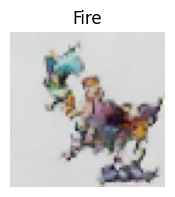

127/127 ━━━━━━━━━━━━━━━━━━━━ 63s 502ms/step - loss: 0.0449
Epoch 141/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0389
Epoch 142/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0428
Epoch 143/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0337
Epoch 144/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0480
Epoch 145/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0861
Epoch 146/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0578
Epoch 147/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0643
Epoch 148/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0766
Epoch 149/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0611
Epoch 150/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0444
Epoch 151/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0507
Epoch 152/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0348
Epoch 153/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms

Sampling sprite: 100%|██████████| 999/999 [00:41<00:00, 23.90it/s]


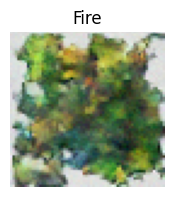

127/127 ━━━━━━━━━━━━━━━━━━━━ 64s 506ms/step - loss: 0.0726
Epoch 161/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0392
Epoch 162/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0397
Epoch 163/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0496
Epoch 164/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0350
Epoch 165/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0331
Epoch 166/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0465
Epoch 167/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0531
Epoch 168/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0558
Epoch 169/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0710
Epoch 170/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0531
Epoch 171/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0416
Epoch 172/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0370
Epoch 173/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms

Sampling sprite: 100%|██████████| 999/999 [00:41<00:00, 24.31it/s]


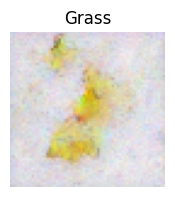

127/127 ━━━━━━━━━━━━━━━━━━━━ 63s 501ms/step - loss: 0.0543
Epoch 181/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0776
Epoch 182/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0567
Epoch 183/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0375
Epoch 184/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0399
Epoch 185/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0313
Epoch 186/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0389
Epoch 187/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0745
Epoch 188/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0531
Epoch 189/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0707
Epoch 190/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0512
Epoch 191/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0431
Epoch 192/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0568
Epoch 193/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms

Sampling sprite: 100%|██████████| 999/999 [00:41<00:00, 24.16it/s]


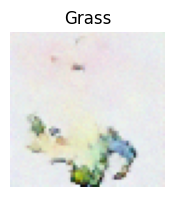

127/127 ━━━━━━━━━━━━━━━━━━━━ 64s 503ms/step - loss: 0.0345
Epoch 201/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0372
Epoch 202/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0453
Epoch 203/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0423
Epoch 204/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0393
Epoch 205/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0441
Epoch 206/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0294
Epoch 207/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0368
Epoch 208/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0417
Epoch 209/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0367
Epoch 210/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0382
Epoch 211/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0389
Epoch 212/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0397
Epoch 213/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms

Sampling sprite: 100%|██████████| 999/999 [00:41<00:00, 24.24it/s]


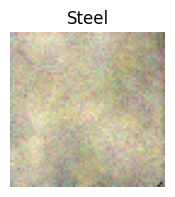

127/127 ━━━━━━━━━━━━━━━━━━━━ 63s 502ms/step - loss: 0.0541
Epoch 221/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0390
Epoch 222/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0400
Epoch 223/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0350
Epoch 224/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0391
Epoch 225/1000
 70/127 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - loss: 0.0334

In [6]:
model.fit(poke_dataset, epochs=1000, callbacks=[DiffusionCallback(model, 20)])

Generating sample 1/3


Sampling sprite: 100%|██████████| 999/999 [00:39<00:00, 25.18it/s]


Generating sample 2/3


Sampling sprite: 100%|██████████| 999/999 [00:43<00:00, 22.86it/s]


Generating sample 3/3


Sampling sprite: 100%|██████████| 999/999 [00:40<00:00, 24.65it/s]


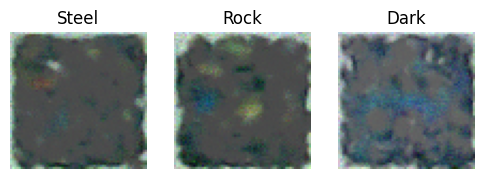

In [ ]:
model.plot_samples(6)

In [ ]:
# import gradio as gr

# poke_diffusion = gr.Interface(
#     fn=model.plot_samples,
#     inputs=gr.Slider(minimum=1, maximum=10, label="Number of samples"),
#     outputs=gr.Image(),
# )

# poke_diffusion.launch(share=True)

## 2.2. Save Model

Finalmente, se guardan los resultados finales del modelo de difusión en un fichero `.h5` para su posterior uso y visualización. TODO: MIRAR OTROS FORMATOS DE GUARDADO

TODO: INVESTIGAR OTROS FORMATOS DE GUARDADO (HDF5, PICKLE, ETC.)

In [ ]:
# Save the model function
# =====================================================================
def save_model(model: tf.keras.models.Model, model_name: str) -> None:
    """Saves the model

    :param model: The model to save
    :param model_name: The name of the model
    :return: None
    """

    # Save the model
    model_dir = "./diffusion_models/models/"
    os.makedirs(model_dir, exist_ok=True)
    if not os.path.exists(os.path.join(model_dir, f"{model_name}.h5")):
        model.save(os.path.join(model_dir, f"{model_name}.h5"))
        print(f"Model {model_name}, saved successfully!")
    else:
        print(f"Model {model_name}, already exists!")

In [ ]:
# Save the model
# model_name = f"diffusion_{IMG_SIZE}_{BATCH_SIZE}_{EPOCHS}_{T}_{scheduler}_ddpm"

# save_model(model, model_name)

[BACK TO TOP](#top)